## Abdul Musa Yusuf

In [99]:
import numpy as np
import pandas as pd
import random as rd
import sys, os
import scipy.io as sio
import pickle 
import matplotlib.pyplot as plt 
import matplotlib.cm as cm  
import matplotlib as mpl
%matplotlib inline
plt.style.use('fivethirtyeight')
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

In [100]:
pkfile = 'realitymining_pick'
datax = open(pkfile,'rb')
s = pickle.load(datax)
datax.close()

In [101]:
subjectID = 17
M17 = s['data_mat'][0,subjectID-1].transpose()
M17.shape

(144, 24)

In [102]:
hours=np.size(M17,1)
days=np.size(M17,0)
num_labels = 5
Mbw17 = np.zeros([days,hours*num_labels])

In [103]:
name_column=[]
for j in range(1,np.size(Mbw17,1)+1):
    J1=hours*(num_labels-1)+1 #97=24*(5-1)+1
    if j >= J1:      
        name_column.append(str(j-J1)+'_off')
    else:
        J2=hours*(num_labels-2)+1
        if j>=J2:
            name_column.append(str(j-J2)+'_nsg')
        else:
            J3=hours*(num_labels-3)+1
            if j >= J3:
                name_column.append(str(j-J3)+'_els')
            else:
                J4=hours*(num_labels-4)+1
                if j >= J4:
                    name_column.append(str(j-J4)+'_wrk')
                else:
                    name_column.append(str(j-1)+'_hom')

In [104]:
# Initiating some conversions

def convert2binary(M17):
    hours=np.size(M17,1)
    days=np.size(M17,0)
    num_labels=5
    Mbw17 = np.zeros([days,hours*num_labels])
    for i in range(1,days+1):
        for j in range(1,hours+1):
            place=M17[i-1][j-1]
            if np.isnan(place):
                Ji=hours*(num_labels-1)+1
                Jf=hours*num_labels 
                J=Ji+j-1
                Mbw17[i-1][J-1]=1
            else:
                if place==0:
                    Ji=hours*(num_labels-2)+1 
                    Jf=hours*(num_labels-1)  
                    J=Ji+j-1
                    Mbw17[i-1][J-1]=1
                else:
                    Ji=int(hours*(place-1)+1)
                    Jf=int(hours*place)    
                    J=int(Ji+j-1)
                    Mbw17[i-1][J-1]=1
    return Mbw17

In [105]:
Mbw17 = convert2binary(M17)

In [106]:
number_c= 100
pca = PCA(n_components=number_c)
pca.fit(Mbw17)
Mbw17_pca=pca.fit_transform(Mbw17)
Mbw17_recons = pca.inverse_transform(Mbw17_pca)

### Problem 1 - Part A

In [107]:
egv = pd.DataFrame(pca.components_)
egv.iloc[[10,15,20], 0:3]

,0,1,2
10,-0.001712,0.078945,0.044448
15,-0.004142,0.008341,-0.030218
20,0.057735,0.030023,-0.007476


### Problem 1 - Part B

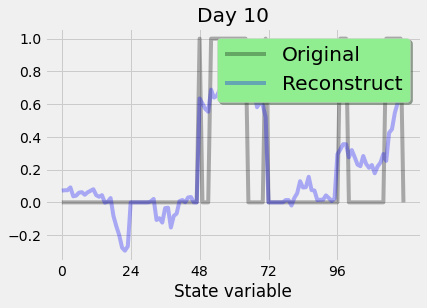

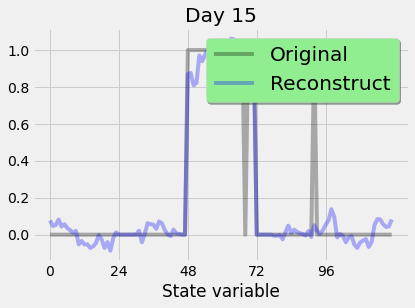

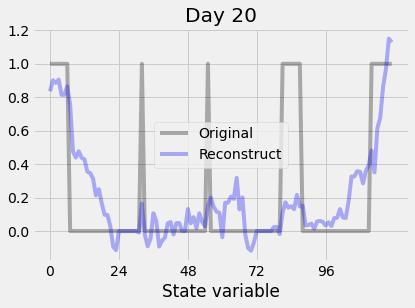

In [129]:
# reconstruction of these three sample days with the first three eigenvectors.
nc = 3
pca_3 = PCA(n_components = nc)  
pca_3.fit(Mbw17)
Mbw17_pca_3 =pca_3.fit_transform(Mbw17)
Mbw17_recons_3 = pca_3.inverse_transform(Mbw17_pca_3[:,:3])


x = np.arange(hours*num_labels)
count = 0
for subject in range(10,21,5):
    fig, ax = plt.subplots()
    ax.plot(x,Mbw17[subject-1], 'k-', color='black', alpha=0.3, label = "Original")
    ax.plot(x,Mbw17_recons_3[subject-1],'k', color='blue', alpha=0.3, label="Reconstruct")
    legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
    legend.get_frame().set_facecolor('lightgreen')
    plt.xticks(np.arange(0, 120, step=24))
    plt.xlabel("State variable")
    plt.title('Day '+str(subject))
    count = +1
plt.legend()
plt.show()

### Problem 1- Part c

In [109]:
n = 120
lvar = pca.explained_variance_ratio_
print('The three first eigen vectors account for {:.3f} of the variance of the data'\
      .format(100%(np.cumsum([0] + list(lvar))[3])))

The three first eigen vectors account for 0.090 of the variance of the data


In [110]:
acc_dict = {10:[], 15:[],20:[]}
eg_75 = {10:None, 15:None,20:None}
# Loop over different number of components
first_occ = True
for n in range (1,121):
    pca_n = PCA(n)
    pca_n.fit(Mbw17)
    Mbw17_projected_n = pca_n.fit_transform(Mbw17)
    Mbw17_recons_n = pca_n.inverse_transform(Mbw17_projected_n[:,:n])
    # loop over different days
    all_75 = True
    for d in [10, 15, 20]:
        acc = 1- np.sum(np.square((Mbw17[d-1]-Mbw17_recons_n[d-1])))/np.sum(np.square(Mbw17[d-1]))
        acc_dict[d].append(acc)
        if acc < 0.75:
            all_75 = False
        elif not eg_75[d]:
            eg_75[d] = n
            print("On day",d,": "" we need" ,n, "eigenvectors.")
    if first_occ and all_75 == True:
        print ("\n{} eigenvectors are ideally needed to make reconstructions for days 10, 15 and 20, with 75% accuracy (values {}, {}, and {}).".format(n, acc_dict[10][n-1],acc_dict[15][n-1],acc_dict[20][n-1]))
        first_occ = False

On day 15 :  we need 2 eigenvectors.
On day 10 :  we need 7 eigenvectors.
On day 20 :  we need 8 eigenvectors.

8 eigenvectors are ideally needed to make reconstructions for days 10, 15 and 20, with 75% accuracy (values 0.7738611337915461, 0.9246026240629172, and 0.8042030577112242).


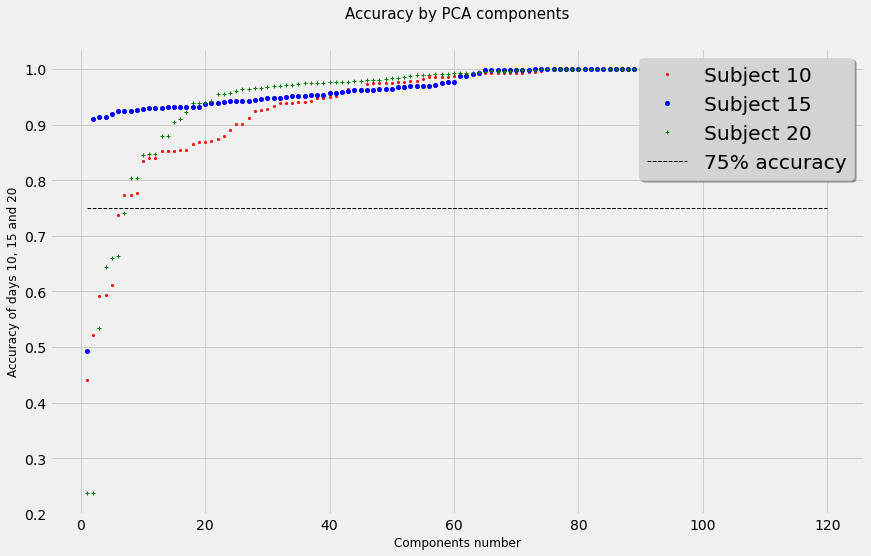

In [111]:
n = 120
plt.figure(figsize = (13,8))
ax = plt.gca()  
plt.plot(range(1, n+1), acc_dict[10],'.',c='r',markersize = 4, label = 'Subject 10')
plt.plot(range(1, n+1), acc_dict[15],'ko',c='b',markersize = 4, label = 'Subject 15')
plt.plot(range(1, n+1), acc_dict[20],'k+',c='g',markersize = 4, label = 'Subject 20')
plt.plot(range(1, n+1),[0.75 for i in range(1, n+1)],'--',c = 'black',
        linewidth = 1,label="75% accuracy")
legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
legend.get_frame().set_facecolor('lightgray')
plt.xlabel('Components number',fontsize = 12)
plt.ylabel('Accuracy of days 10, 15 and 20',fontsize = 12)
plt.title('Accuracy by PCA components',fontsize = 15, y = 1.05)
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
ax.grid(True)
plt.show()

### Problem 1- Part d

In [112]:
# identify a day that is the worst reconstructed by the first 3 eigenbehaviors?

print("Ideal reconstruction of accuracy with 3 eigenvectors:")
for i in [10, 15, 20]:
    print("- Day {}:".format(i), acc_dict[i][3])

Ideal reconstruction of accuracy with 3 eigenvectors:
- Day 10: 0.5944394471460341
- Day 15: 0.9143143087207491
- Day 20: 0.6438493409101893


In [113]:
p17 = PCA(3)
MBW_recons = pca17_3.inverse_transform(p17.fit_transform(Mbw17))

con = 1.00 - np.sum(np.square((Mbw17 - MBW_recons)),axis=1)/np.sum(np.square(Mbw17),axis=1)
print('The Ideal worst reconstruction is Day', np.argmin(con) + 1,'with Accuracy',np.min(con))

The Ideal worst reconstruction is Day 36 with Accuracy 0.265064211896065


## Part 1 - Comparing Subjects 

In [114]:
# Accounting for the required subjects..
M16 = s['data_mat'][0,16-1].transpose()
Mbw16 = convert2binary(M16)
M17 = s['data_mat'][0,17-1].transpose()
Mbw17 = convert2binary(M17)
M25 = s['data_mat'][0,25-1].transpose()
Mbw25 = convert2binary(M25)

In [130]:
M = {16: Mbw16, 17: Mbw17, 25: Mbw25}

km_list = {16: None, 17:None, 25: None}
n_clusters = 3
for i in [16,17,25]:
    pca = PCA(n_components = 120)
    pca.fit(M[i])
    Mbw_proj = pca.fit_transform(M[i])
    km = KMeans(n_clusters=n_clusters)
    km = km.fit(Mbw_proj)

    PC_dictionnary = {}
    Principal_components_names = ['PC ' + str(i) for i in range(1,len(name_column)+1)]
    for idx in range(len(Principal_components_names)):
        PC_dictionnary[Principal_components_names[idx]] = pca.components_[idx]
    PC_data = pd.DataFrame(data = PC_dictionnary) 
    PC_data['Variables'] = name_column
    PC_data = PC_data.set_index(PC_data['Variables'])
    # retrieve clusters..
    centers = km.cluster_centers_
    centers_initial_base = pca.inverse_transform(centers)
    clusters_dictionnary = {}
    Clusters_names = ['Cluster ' + str(i) for i in range(0,n_clusters)]
    for idx in range(len(Clusters_names)):
        clusters_dictionnary[Clusters_names[idx]] = centers_initial_base[idx,:]
    
    clusters_data = pd.DataFrame(data = clusters_dictionnary)
    clusters_data['Variables'] = name_column
    clusters_data = clusters_data.set_index(PC_data['Variables'])
    del clusters_data['Variables']
    km_list[i] = clusters_data

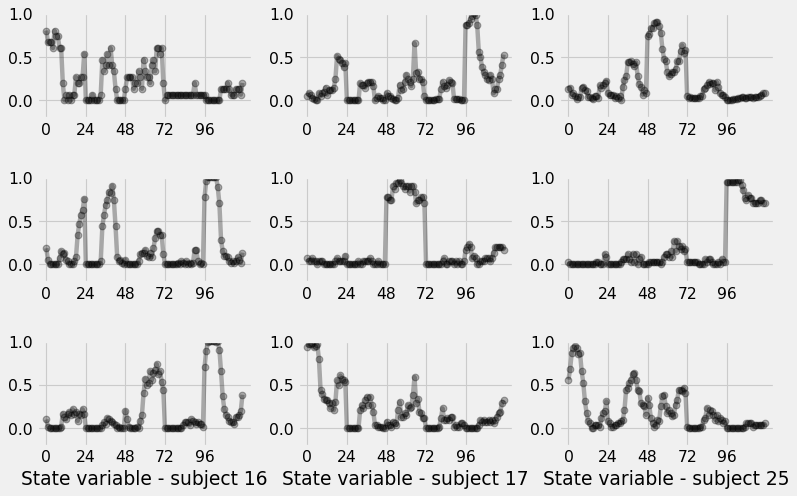

In [131]:
x = np.arange(hours*num_labels)

index = 0
fig = plt.figure(figsize=(10, 10), dpi=80)
for c in range(n_clusters):  
    for s in [16,17,25]:
        index +=1
        plt.subplot(5, 3, index)
        plt.plot(x,km_list[s]['Cluster {}'.format(c)].values, 'o-', color='black', alpha=0.3)
        plt.ylim([-0.2, 1.0])
        plt.xticks(np.arange(0, 120, step = 24))
        if c == n_clusters-1: 
            plt.xlabel("State variable - subject {}".format(s))
        if s == 4: 
            plt.ylabel("Centroids - cluser {}".format(c))
fig.tight_layout()

plt.show()

## Problem 2 - Part 1 

In [117]:
df = pd.read_csv("TypicalWeekdayProfile.txt", delimiter = "\t", header = None)

In [118]:
print('Shape:', df.shape)

Shape: (1255, 96)


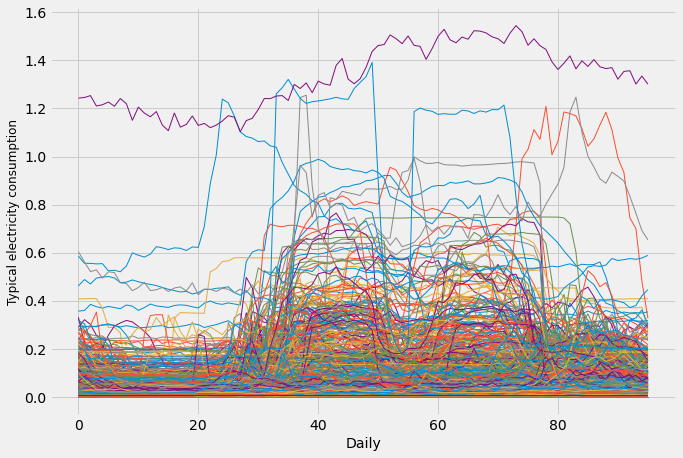

In [119]:
# plotting the data
plt.figure(figsize = (10,7))
plt.plot(list(range(96)), df.transpose().to_numpy(), linewidth=1)
plt.ylabel('Typical electricity consumption',fontsize = 12)
plt.xlabel('Daily',fontsize = 14)
plt.show()

## Problem 2 - Part 2

In [120]:
n = 90
pca = PCA(n)
pca.fit(df)

PCA(n_components=90)

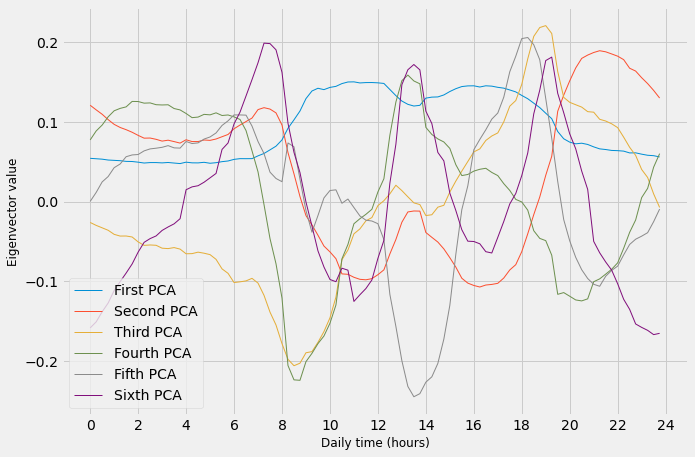

In [121]:
plt.figure(figsize = (10,7))
plot = plt.plot(list(range(96)), pca.components_[:6].transpose(), linewidth=1)
plt.xticks(list(range(0,96+int((96/12)),int(96/12))),list(range(0,25,2)))
plt.ylabel('Eigenvector value',fontsize = 12)
plt.xlabel('Daily time (hours)',fontsize = 12)
plt.legend(iter(plot), ("First PCA", "Second PCA", "Third PCA", "Fourth PCA", "Fifth PCA", "Sixth PCA"))
plt.show()

## Problem 2 - Part 3

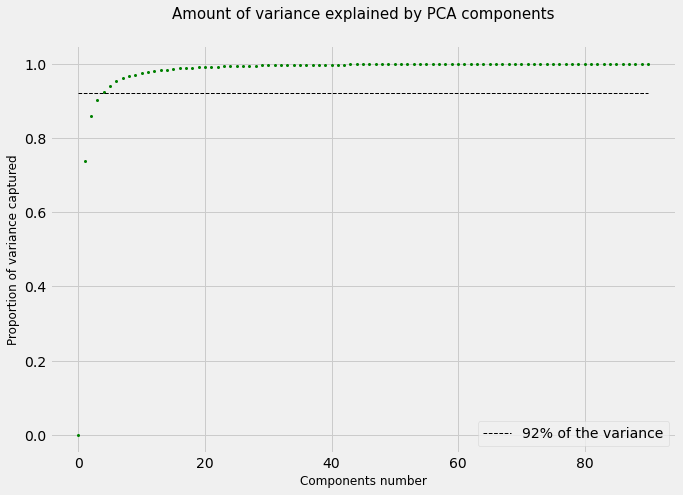

In [122]:
list_variance = pca.explained_variance_ratio_

plt.figure(figsize = (10,7))
ax = plt.gca()
plt.plot(range(0, n+1), np.cumsum([0] + list(list_variance)),'.',c='g',markersize = 4)
plt.plot(range(0, n+1),[0.92 for i in range(0, n+1)],'--',c = 'black',
         linewidth = 1,label="92% of the variance")
plt.legend()
plt.xlabel('Components number',fontsize = 12)
plt.ylabel('Proportion of variance captured',fontsize = 12)
plt.title('Amount of variance explained by PCA components',fontsize = 15, y = 1.05)
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
ax.grid(True)
plt.show()

**Four K eigenvectors are ideally needed to explain at least 92% of the variance.** 

## Problem 2 - Part 3

In [123]:
n = 96
pca = PCA(n)
pca.fit(df)
k = 4
projected_data = pca.fit_transform(df)
km = KMeans(n_clusters=k)
km = km.fit(projected_data)

phi_km = km.fit_predict(projected_data)

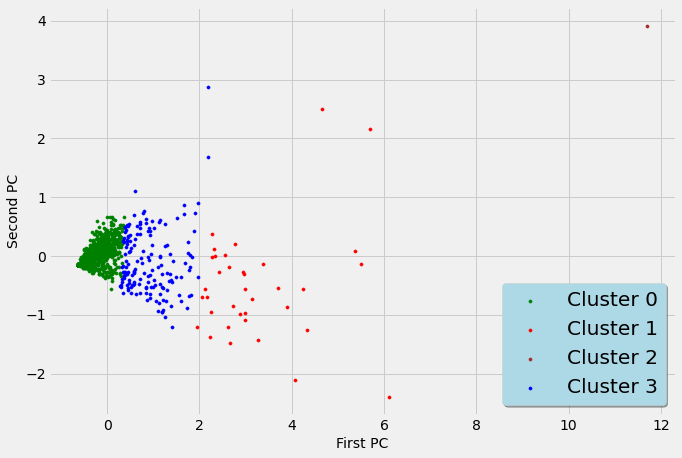

In [124]:
colors = ['green', 'red', 'brown', 'blue']
plt.figure(figsize = (10,7))
ax = plt.gca()  
for i in range(k):
    plt.scatter(projected_data[phi_km ==i,0], projected_data[phi_km == i,1], s=10, c=colors[i], label = "Cluster {}".format(i))
legend = ax.legend(loc = 'lower right', shadow=True, fontsize='x-large')
legend.get_frame().set_facecolor('lightblue')
plt.xlabel('First PC',fontsize = 14)
plt.ylabel('Second PC',fontsize = 14)
plt.show()

## Problem 2 - Part 4

Cluster 1:
• The average consumption is : 0.040875716453800046
• The number of accounts is: 1057
Cluster 2:
• The average consumption is : 0.34585543981481515
• The number of accounts is: 36
Cluster 3:
• The average consumption is : 1.328368750000001
• The number of accounts is: 1
Cluster 4:
• The average consumption is : 0.14527791796066258
• The number of accounts is: 161


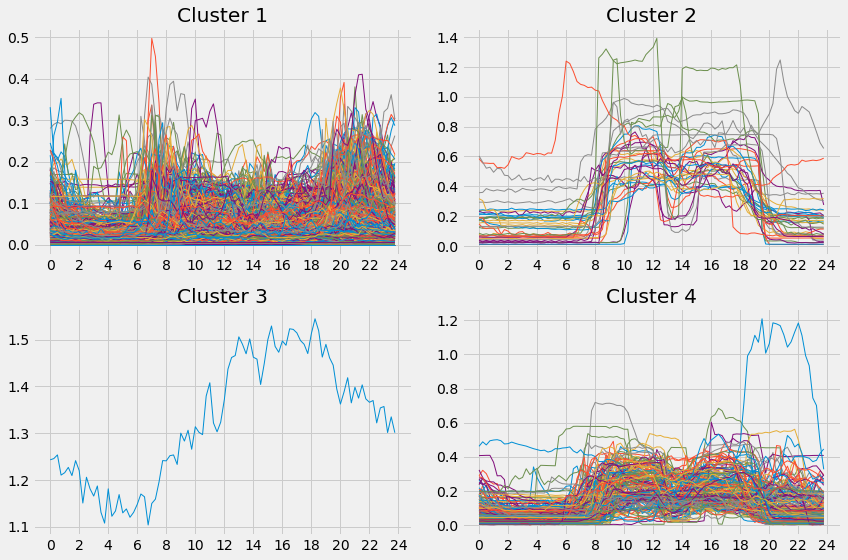

In [125]:
cluster = []
plt.figure(figsize = (12,8))
for i in range(k):
    cluster_data = pca.inverse_transform(projected_data[phi_km ==i,:])
    print("Cluster {}:".format(i + 1))
    print("• The average consumption is :", cluster_data.mean())
    print("• The number of accounts is:", len(cluster_data))
    plt.subplot(2,2,i+1)
    plt.plot(list(range(96)), cluster_data.transpose(), linewidth=1)
    plt.xticks(list(range(0,96+int((96/12)),int(96/12))),list(range(0,25,2)))
    plt.title('Cluster '+str(i + 1))
plt.tight_layout()
plt.show()